# Load Datasets

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

playerdata_1718season = '.\playerstatsbygame_20172018_regularseason.csv'
playerseason_data = '.\Seasons_Stats.csv'
salarydata = './nba_salaries_1990_to_2018.csv'
rpm_data = './RPM_data.xlsx'

playerstats_1718 = pd.read_csv(playerdata_1718season)
playerseasondata = pd.read_csv(playerseason_data)
salarydata = pd.read_csv(salarydata)
rpmdata = pd.read_excel(rpm_data, sheet_name='Agg')

## Creating clean dataset to work with:
- Remap team names to match between stats & salary data
- Combine salary & stats by merging datasets on [Player, Year, Team], for seasons ending 1990-2017
- Get rid of duplicate/unnecessary columns
- Rename columns

In [2]:
# Team names are slightly different between stats & salary, so need to remap before joining:

team_map = {'ATL': 'ATL','BOS': 'BOS','BRK': 'NJN','CHA': 'CHA','CHH': 'CHA','CHI': 'CHI','CHO': 'CHA',
'CLE': 'CLE','DAL': 'DAL','DEN': 'DEN','DET': 'DET','GSW': 'GSW','HOU': 'HOU','IND': 'IND','LAC': 'LAC',
'LAL': 'LAL','MEM': 'MEM','MIA': 'MIA','MIL': 'MIL','MIN': 'MIN','NJN': 'NJN','NOH': 'NOH','NOK': 'NOH',
'NOP': 'NOP','NYK': 'NYK','OKC': 'OKC','ORL': 'ORL','PHI': 'PHI','PHO': 'PHO','POR': 'POR','SAC': 'SAC',
'SAS': 'SAS','SEA': 'SEA','TOR': 'TOR','TOT': 'TOT','UTA': 'UTA','VAN': 'MEM','WAS': 'WAS','WSB': 'WAS'}

playerseasondata['Tm'] = playerseasondata['Tm'].map(team_map)

In [3]:
# combine salary data (1990 - 2017 season end) with stats for one giant player table
# Note, each year is the season end year
# Combine based on player, season, & team (players may have played on >1 team in a season, so this makes sure we join right)

stats = playerseasondata.loc[playerseasondata.loc[:, 'Year'] > 1990, :]
salary = salarydata.loc[salarydata.loc[:, 'season_end'] <=2017, :]
data = stats.merge(salary, left_on=['Player', 'Year', 'Tm' ], right_on = ['player', 'season_end', 'team'], how='outer')

#get rid of columns I don't want/duplicates and rename existing for clarity

data.drop(['Unnamed: 0','3PAr', 'blank2',
 'blanl', 'BPM', 'DBPM', 'eFG%', 'FTr', 'OBPM', 'team_name', 'VORP', 'WS/48', 'FG%', 'FGA', 'FG'], axis=1, inplace=True)

data.rename(columns={ '2PA':'2PAttempt', '2P':'2PMade', '2P%':'2Pt%', '3P%':'3Pt%',
 '3PA':'3PtAttempt', '3P':'3PtMade', 'Age':'Age_seasonEnd', 'AST%':'Assist%',
 'AST':'Assists', 'BLK%':'Block%', 'BLK':'Blocks', 'DRB%':'Drebound%',
 'DRB':'Drebounds', 'DWS': 'Dwinshares','FT%':'FT%', 'FTA':'FTAttempt', 'FT':'FTMade', 'G':'Games',
 'GS':'GamesStarted', 'MP':'MinPlayed', 'ORB':'Offrb', 'ORB%':'OffRb%',
 'OWS': 'OffWinShares', 'PER':'PER', 'PF':'PersonalFouls', 'Player':'Player', 'player':'player',
 'Pos':'Position', 'PTS':'Pts', 'salary':'Salary', 'season_end':'Season_End',
 'season_start':'Season_Start', 'STL%':'Steal%', 'STL':'Steals',
 'team':'Team', 'Tm': 'Stats_Team', 'TRB%':'TotalRbnd%', 'TRB':'TotalRbnds',
 'TS%':'TS%', 'TOV':'Turnover', 'TOV%':'Turnover%','USG%':'Usg%', 'WS':'WinShares', 'Year': 'Stats_SeasonEnd'}, inplace=True)

data.head()

data.drop(['player', 'Season_End', 'Season_Start', 'Team'], axis=1, inplace=True)

# EDA time

## Dealing with missing values:
- There are a lot of missing values initially:
    - Stats dataset loaded all '0' stats as NaN, so replace with 0s
    - Joining the salary & stats tables via 'outer' join allowed for a lot of blanks where tables didn't both have data
- For missing salary data, I chose to add the average salary of the player if they have >1 entry.  If the player has just one entry and salary is missing, I am getting rid of the datapoint.

In [4]:
data.isnull().sum()

Stats_SeasonEnd    1446
Player             1446
Position           1446
Age_seasonEnd      1446
Stats_Team         1446
Games              1446
GamesStarted       1446
MinPlayed          1446
PER                1451
TS%                1516
OffRb%             1451
Drebound%          1451
TotalRbnd%         1451
Assist%            1451
Steal%             1451
Block%             1451
Turnover%          1503
Usg%               1451
OffWinShares       1446
Dwinshares         1446
WinShares          1446
3PtMade            1446
3PtAttempt         1446
3Pt%               4049
2PMade             1446
2PAttempt          1446
2Pt%               1549
FTMade             1446
FTAttempt          1446
FT%                2077
Offrb              1446
Drebounds          1446
TotalRbnds         1446
Assists            1446
Steals             1446
Blocks             1446
Turnover           1446
PersonalFouls      1446
Pts                1446
Salary             4779
dtype: int64

In [5]:
#For NaN stats values, a '0' is an acceptable number, so will fill in missing stats with 0.

fillwithzero = ['Games',
 'GamesStarted',
 'MinPlayed',
 'PER',
 'TS%',
 'OffRb%',
 'Drebound%',
 'TotalRbnd%',
 'Assist%',
 'Steal%',
 'Block%',
 'Turnover%',
 'Usg%',
 'WinShares',
 '3PtMade',
 '3PtAttempt',
 '3Pt%',
 '2PMade',
 '2PAttempt',
 '2Pt%',
 'FTMade',
 'FTAttempt',
 'FT%',
 'Offrb',
 'Drebounds',
 'TotalRbnds',
 'Assists',
 'Steals',
 'Blocks',
 'Turnover',
 'PersonalFouls',
 'Pts']

data[fillwithzero] = data[fillwithzero].fillna(value=0)

In [6]:
#Missing salary count by season:
missing_sal = data.loc[:, ['Stats_SeasonEnd', 'Salary', 'Player']].groupby('Stats_SeasonEnd').count()
missing_sal['ratio'] = missing_sal['Salary']/missing_sal['Player']
missing_sal

,Salary,Player,ratio
Stats_SeasonEnd,,,
1991.0,333,441,0.755102
1992.0,320,458,0.698690
1993.0,316,449,0.703786
1994.0,335,481,0.696466
1995.0,289,452,0.639381
1996.0,353,545,0.647706
1997.0,352,574,0.613240
1998.0,321,547,0.586837
1999.0,325,507,0.641026


In [7]:
playermedsal = data.loc[:, ['Player', 'Salary']].groupby('Player').median()
playermedsal = playermedsal.to_dict()
playermedsal = playermedsal['Salary']

data.Salary = data.Salary.fillna(data.Player.map(playermedsal))

salaryplayercount = data.loc[:, ['Stats_SeasonEnd', 'Salary', 'Player']].groupby('Stats_SeasonEnd').count()
salaryplayercount['ratio'] = salaryplayercount['Salary'] / salaryplayercount['Player']
salaryplayercount

#Majority of rows now have a salary attached

,Salary,Player,ratio
Stats_SeasonEnd,,,
1991.0,405,441,0.918367
1992.0,440,458,0.960699
1993.0,436,449,0.971047
1994.0,460,481,0.956341
1995.0,435,452,0.962389
1996.0,527,545,0.966972
1997.0,552,574,0.961672
1998.0,538,547,0.983547
1999.0,498,507,0.982249


In [8]:
# Drop any rows where salary is still 0:

data.dropna(subset=['Salary'], inplace = True)
salaryplayercount = data.loc[:, ['Stats_SeasonEnd', 'Salary', 'Player']].groupby('Stats_SeasonEnd').count()
salaryplayercount['ratio'] = salaryplayercount['Salary'] / salaryplayercount['Player']
salaryplayercount

,Salary,Player,ratio
Stats_SeasonEnd,,,
1991.0,405,405,1.0
1992.0,440,440,1.0
1993.0,436,436,1.0
1994.0,460,460,1.0
1995.0,435,435,1.0
1996.0,527,527,1.0
1997.0,552,552,1.0
1998.0,538,538,1.0
1999.0,498,498,1.0


In [9]:
data.isnull().sum()

Stats_SeasonEnd    1446
Player             1446
Position           1446
Age_seasonEnd      1446
Stats_Team         1446
Games                 0
GamesStarted          0
MinPlayed             0
PER                   0
TS%                   0
OffRb%                0
Drebound%             0
TotalRbnd%            0
Assist%               0
Steal%                0
Block%                0
Turnover%             0
Usg%                  0
OffWinShares       1446
Dwinshares         1446
WinShares             0
3PtMade               0
3PtAttempt            0
3Pt%                  0
2PMade                0
2PAttempt             0
2Pt%                  0
FTMade                0
FTAttempt             0
FT%                   0
Offrb                 0
Drebounds             0
TotalRbnds            0
Assists               0
Steals                0
Blocks                0
Turnover              0
PersonalFouls         0
Pts                   0
Salary                0
dtype: int64

In [10]:
# Drop rows where player data is null:
data.dropna(subset=['Player'], inplace=True)
data.groupby(['Stats_Team', 'Stats_SeasonEnd']).count()

Player  Position  Age_seasonEnd  Games  \
Stats_Team Stats_SeasonEnd                                           
ATL        1991.0               14        14             14     14   
           1992.0               15        15             15     15   
           1993.0               17        17             17     17   
           1994.0               14        14             14     14   
           1995.0               18        18             18     18   
           1996.0               17        17             17     17   
           1997.0               17        17             17     17   
           1998.0               16        16             16     16   
           1999.0               14        14             14     14   
           2000.0               14        14             14     14   
           2001.0               21        21             21     21   
           2002.0               17        17             17     17   
           2003.0               20        20             20     20   
           2004.0               22        22             22     22   
           2005.0               20        20             20     20   
           2006.0               14        14             14     14   
           2007.0               19        19             19     19   
           2008.0               16        16             16     16   
           2009.0               15        15             15     15   
           2010.0               14        14             14     14   
           2011.0               17        17             17     17   
           2012.0               16        16             16     16   
           2013.0               18        18             18     18   
           2014.0               17        17             17     17   
           2015.0               16        16             16     16   
           2016.0               17        17             17     17   
           2017.0               20        20             20     20   
BOS        1991.0               15        15             15     15   
           1992.0               18        18             18     18   
           1993.0               17        17             17     17   
...                            ...       ...            ...    ...   
UTA        2015.0               21        21             21     21   
           2016.0               17        17             17     17   
           2017.0               15        15             15     15   
WAS        1991.0               14        14             14     14   
           1992.0               15        15             15     15   
           1993.0               18        18             18     18   
           1994.0               18        18             18     18   
           1995.0               16        16             16     16   
           1996.0               19        19             19     19   
           1997.0               15        15             15     15   
           1998.0               16        16             16     16   
           1999.0               14        14             14     14   
           2000.0               16        16             16     16   
           2001.0               20        20             20     20   
           2002.0               14        14             14     14   
           2003.0               16        16             16     16   
           2004.0               17        17             17     17   
           2005.0               15        15             15     15   
           2006.0               15        15             15     15   
           2007.0               16        16             16     16   
           2008.0               13        13             13     13   
           2009.0               17        17             17     17   
           2010.0               24        24             24     24   
           2011.0               22        22             22     22   
           2012.0               20    

### Adding some columns for analysis:
- Shifted salary & win share columns by 1 season, so each row has the player's next season salary & overall winshares attached
- Adding a dummy variable for position
- Adding a column with that season's salary cap (not adjusted for inflation), and the calculated % of salary cap for each player per season
    - NOTE, not every team's salary would have added up to 100% of the salary cap each season, but as I have missing salary data for some players, I did not want to just add up the total salary by team by year.

In [11]:
#Add shifted salary & win share columns, so we can compare stats to a player's next year salary and impact
data['next_season_salary'] = data.groupby(['Player'])['Salary'].shift(-1)
data['next_season_winshares'] = data.groupby(['Player'])['WinShares'].shift(-1)
data['next_season_off_winshares'] = data.groupby(['Player'])['OffWinShares'].shift(-1)
data['next_season_def_winshares'] = data.groupby(['Player'])['Dwinshares'].shift(-1)

In [12]:
#Add a column for # of years player has been in league
player_min_year = pd.DataFrame(playerseasondata.groupby('Player')['Year'].min())
player_min_year = player_min_year.to_dict()
player_min_year = player_min_year['Year']
data['Player_first_year'] = data.Player.map(player_min_year)
data['Years_Playing'] = data['Stats_SeasonEnd'] - data['Player_first_year']

In [13]:
data.Position.value_counts()

position_map = {'PF': 1, 'PG': 2, 'C': 3, 'SG': 4, 'SF': 5, 'PG-SG': 6, 'SG-PG': 6, 'SG-SF': 7, 'SF-SG': 7,
               'C-PF': 8, 'PF-SF': 9, 'PF-C':8, 'SF-PF': 9, 'SG-PF': 10, 'C-SF': 11, 'PG-SF':1}

data['Position_Mapped'] = data['Position'].map(position_map)

In [14]:
# Add a column with that year's salary cap (source: basketball-reference.com)
# Add a column for salary as % of salary cap

salary_cap_by_year = {1990: 9802000,1991: 11871000,1992: 12500000,1993: 14000000,
1994: 15175000,1995: 15964000,1996: 23000000,1997: 24363000,1998: 26900000,1999: 30000000,
2000: 34000000,2001: 35500000,2002: 42500000,2003: 40271000,2004: 43840000,2005: 43870000,
2006: 49500000,2007: 53135000,2008: 55630000,2009: 58680000,2010: 57700000,2011: 58044000,
2012: 58044000,2013: 58044000,2014: 58679000,2015: 63065000,2016: 70000000,2017: 94143000}
data['Season_Salary_Cap'] = data['Stats_SeasonEnd'].map(salary_cap_by_year)
data['Salary_as_percent_of_cap'] = data['Salary'] / data['Season_Salary_Cap']
data['next_season_salary_as_percent_of_cap'] = data.groupby(['Player'])['Salary_as_percent_of_cap'].shift(-1)

## More EDA

- Data shape
- Data types
- Count of null values by column
- Basic summary statistics
- Number of unique values for each column
- Plot of the distribution of each column (e.g. histogram, bar plot, or box plot)
- Scatterplot of each column with salary

In [15]:
print("Shape:", data.shape, '\n')
print("Types:", data.dtypes, '\n')
print("Null counts:", data.isnull().sum(), '\n')

Shape: (14336, 50) 

Types: Stats_SeasonEnd                         float64
Player                                   object
Position                                 object
Age_seasonEnd                           float64
Stats_Team                               object
Games                                   float64
GamesStarted                            float64
MinPlayed                               float64
PER                                     float64
TS%                                     float64
OffRb%                                  float64
Drebound%                               float64
TotalRbnd%                              float64
Assist%                                 float64
Steal%                                  float64
Block%                                  float64
Turnover%                               float64
Usg%                                    float64
OffWinShares                            float64
Dwinshares                              float64
WinShares   

Null values for next season shifted data are OK

In [16]:
data.describe()

,Stats_SeasonEnd,Age_seasonEnd,Games,GamesStarted,MinPlayed,PER,TS%,OffRb%,Drebound%,TotalRbnd%,...,next_season_salary,next_season_winshares,next_season_off_winshares,next_season_def_winshares,Player_first_year,Years_Playing,Position_Mapped,Season_Salary_Cap,Salary_as_percent_of_cap,next_season_salary_as_percent_of_cap
count,14336.000000,14336.000000,14336.000000,14336.000000,14336.000000,14336.000000,14336.000000,14336.000000,14336.000000,14336.000000,...,1.231400e+04,12314.00000,12314.000000,12314.000000,14336.000000,14336.000000,14336.000000,1.433600e+04,14336.000000,12314.000000
mean,2004.719866,27.028669,48.985840,23.537319,1149.787040,12.526067,0.502633,5.985107,14.041016,10.015988,...,3.463555e+06,2.55402,1.337388,1.215300,1999.643834,5.076032,2.991629,4.432854e+07,0.073927,0.079436
std,7.682208,4.182305,26.107024,28.317939,911.585896,6.104698,0.098701,5.002702,6.535460,5.072618,...,3.983517e+06,2.99627,2.056695,1.230446,8.770211,4.614116,1.494718,1.995042e+07,0.080272,0.082557
min,1991.000000,18.000000,1.000000,0.000000,0.000000,-90.600000,0.000000,0.000000,0.000000,0.000000,...,5.000000e+03,-1.60000,-2.800000,-1.000000,1958.000000,0.000000,1.000000,1.187100e+07,0.000055,0.000055
25%,1998.000000,24.000000,26.000000,0.000000,319.000000,9.700000,0.472000,2.300000,9.300000,6.100000,...,9.212500e+05,0.30000,0.000000,0.300000,1993.000000,1.000000,2.000000,2.690000e+07,0.019299,0.021735
50%,2005.000000,26.000000,53.000000,9.000000,970.000000,12.700000,0.516000,4.800000,13.100000,9.100000,...,2.000000e+06,1.50000,0.600000,0.800000,2000.000000,4.000000,3.000000,4.387000e+07,0.047096,0.053181
75%,2011.000000,30.000000,74.000000,45.000000,1853.000000,15.700000,0.551000,8.900000,18.200000,13.400000,...,4.453750e+06,3.90000,2.100000,1.800000,2006.000000,8.000000,4.000000,5.804400e+07,0.100000,0.107731
max,2017.000000,44.000000,85.000000,83.000000,3533.000000,129.100000,1.136000,100.000000,100.000000,100.000000,...,3.314000e+07,20.40000,14.800000,9.100000,2017.000000,47.000000,11.000000,9.414300e+07,1.237122,1.237122


#### Description notes:
- Most stats look right, note that there are a few instances in where salary as % of cap is >100%; those are for Michael Jordan in the 90's; most of the salaries are <50% of salary cap

In [17]:
data.sort_values(by='Salary_as_percent_of_cap', ascending=False)

,Stats_SeasonEnd,Player,Position,Age_seasonEnd,Stats_Team,Games,GamesStarted,MinPlayed,PER,TS%,...,next_season_salary,next_season_winshares,next_season_off_winshares,next_season_def_winshares,Player_first_year,Years_Playing,Position_Mapped,Season_Salary_Cap,Salary_as_percent_of_cap,next_season_salary_as_percent_of_cap
9920,1997.0,Michael Jordan,SG,33.0,CHI,82.0,82.0,3106.0,27.8,0.567,...,33140000.0,15.8,10.4,5.4,1985,12.0,4,24363000,1.237122,1.231970
9921,1998.0,Michael Jordan,SG,34.0,CHI,82.0,82.0,3181.0,25.2,0.533,...,1000000.0,3.3,1.2,2.1,1985,13.0,4,26900000,1.231970,0.023529
12546,1995.0,Shaquille O'Neal,C,22.0,ORL,79.0,79.0,2923.0,28.6,0.588,...,5700000.0,6.9,3.9,3.0,1993,2.0,3,15964000,1.208075,0.247826
12632,1991.0,Shawn Kemp,PF,21.0,SEA,81.0,66.0,2442.0,17.6,0.551,...,10260000.0,6.7,3.6,3.0,1990,1.0,1,11871000,0.864291,0.820800
12633,1992.0,Shawn Kemp,PF,22.0,SEA,64.0,23.0,1808.0,21.6,0.567,...,10260000.0,9.1,4.0,5.1,1990,2.0,1,12500000,0.820800,0.732857
10806,1996.0,Patrick Ewing,C,33.0,NYK,76.0,76.0,2783.0,20.9,0.516,...,3000000.0,9.8,2.9,6.9,1986,10.0,3,23000000,0.814087,0.123138
10808,1998.0,Patrick Ewing,C,35.0,NYK,26.0,26.0,848.0,23.3,0.557,...,18500000.0,3.3,0.2,3.1,1986,12.0,3,26900000,0.762082,0.616667
12634,1993.0,Shawn Kemp,PF,23.0,SEA,78.0,68.0,2582.0,20.4,0.547,...,10260000.0,11.7,5.6,6.0,1990,3.0,1,14000000,0.732857,0.676112
8122,1997.0,Kevin Garnett,SF,20.0,MIN,77.0,77.0,2995.0,18.2,0.537,...,2109120.0,9.6,5.3,4.2,1996,1.0,5,24363000,0.714327,0.078406
12635,1994.0,Shawn Kemp,PF,24.0,SEA,79.0,73.0,2597.0,22.9,0.593,...,10260000.0,10.6,5.9,4.7,1990,4.0,1,15175000,0.676112,0.642696


In [18]:
for col in data.columns:
    print(col, data.loc[:, col].nunique())

Stats_SeasonEnd 27
Player 2022
Position 16
Age_seasonEnd 27
Stats_Team 33
Games 85
GamesStarted 84
MinPlayed 3118
PER 494
TS% 562
OffRb% 275
Drebound% 386
TotalRbnd% 299
Assist% 502
Steal% 103
Block% 125
Turnover% 379
Usg% 381
OffWinShares 164
Dwinshares 86
WinShares 195
3PtMade 240
3PtAttempt 552
3Pt% 396
2PMade 729
2PAttempt 1315
2Pt% 456
FTMade 563
FTAttempt 690
FT% 621
Offrb 349
Drebounds 696
TotalRbnds 933
Assists 702
Steals 214
Blocks 252
Turnover 321
PersonalFouls 328
Pts 1825
Salary 5128
next_season_salary 4580
next_season_winshares 193
next_season_off_winshares 159
next_season_def_winshares 86
Player_first_year 44
Years_Playing 48
Position_Mapped 11
Season_Salary_Cap 25
Salary_as_percent_of_cap 8656
next_season_salary_as_percent_of_cap 7616


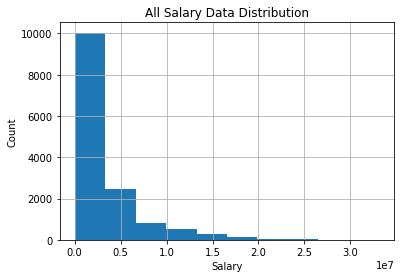

In [19]:
data['Salary'].hist()
plt.title('All Salary Data Distribution');
plt.xlabel('Salary')
plt.ylabel('Count');

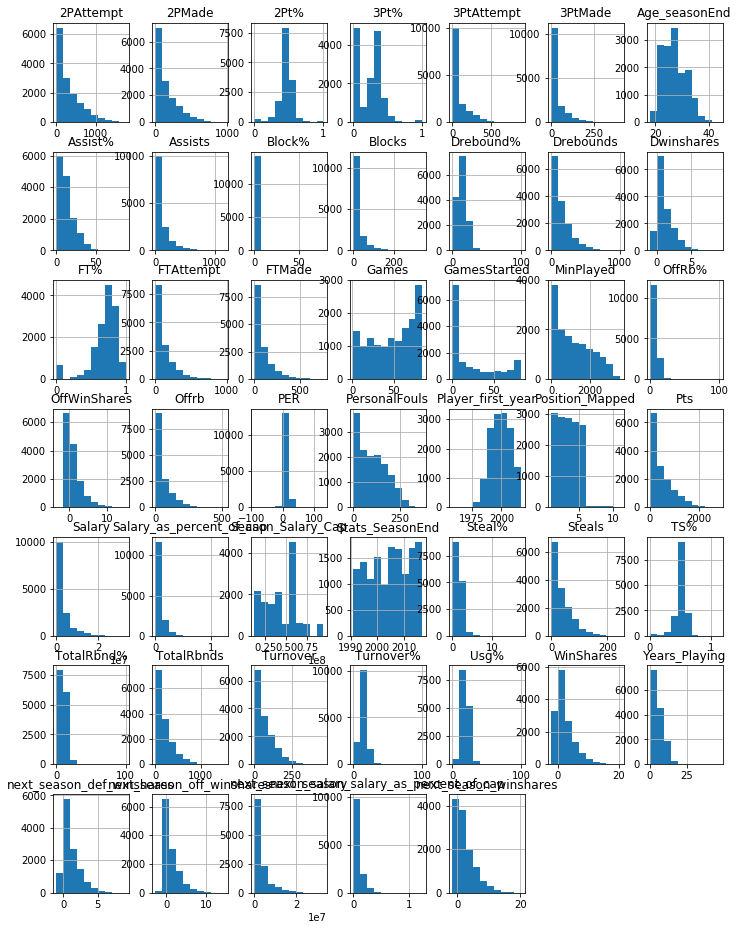

In [20]:
data.hist(figsize=(12,16));

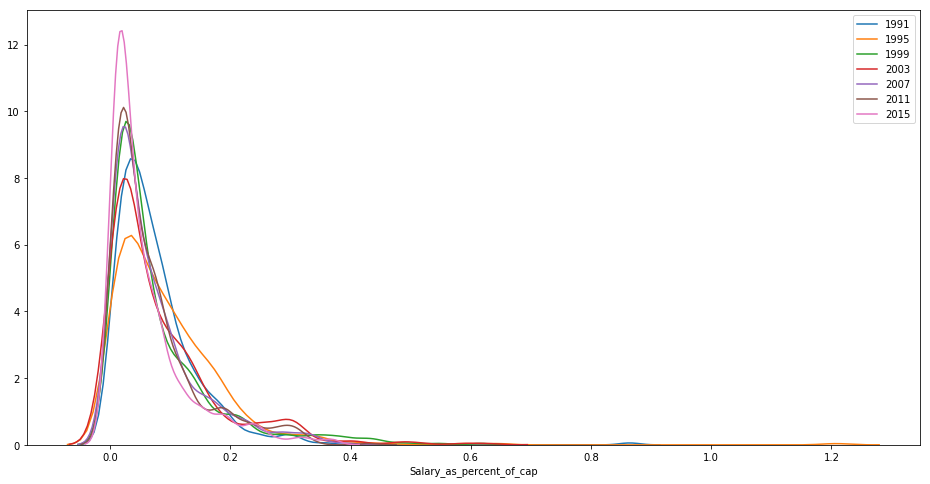

In [21]:
fig, ax = plt.subplots(figsize = (16,8))
ax.xmin = 0
for season in range(1991, 2018, 4):
    season_data = data.loc[data.loc[:, 'Stats_SeasonEnd'] == season, :]
    sns.distplot(season_data['Salary_as_percent_of_cap'], hist=False, ax=ax, label=season)


Salary distribution has pretty much been the same throughout the years; there is a longtail of players who get a lot of $$$, but majority of players get somewhere in the 0-15% of cap range

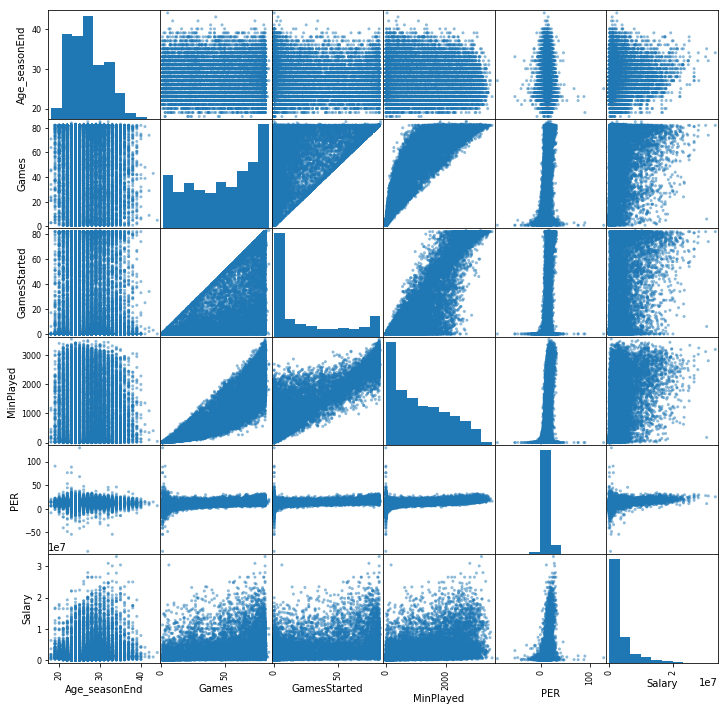

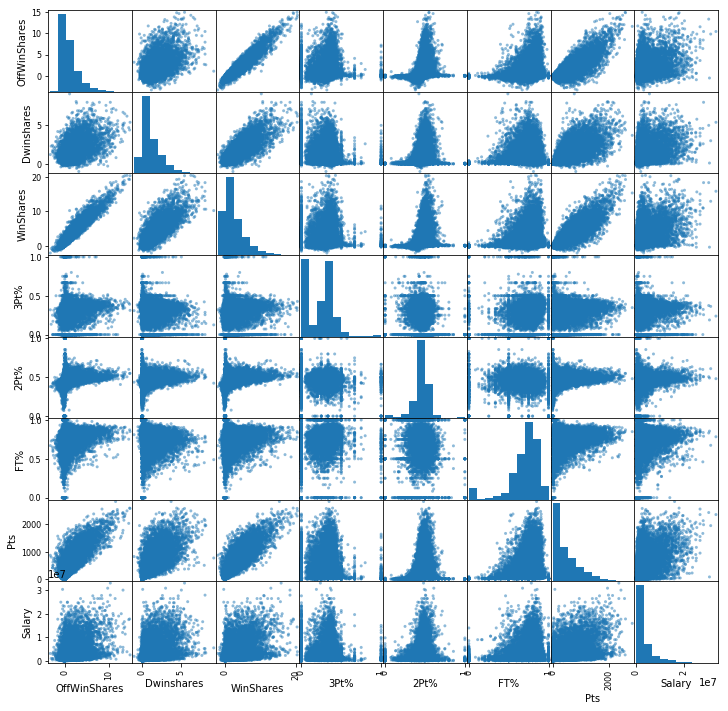

In [22]:
#running several scatter_matrix plots because it's a lot to look at...
pd.plotting.scatter_matrix(data.loc[:, ['Age_seasonEnd', 'Games', 'GamesStarted',
 'MinPlayed', 'PER', 'Salary']], figsize=(12, 12));

pd.plotting.scatter_matrix(data.loc[:, ['OffWinShares', 'Dwinshares', 'WinShares',
                                        '3Pt%','2Pt%', 'FT%', 'Pts', 'Salary']], figsize=(12, 12));


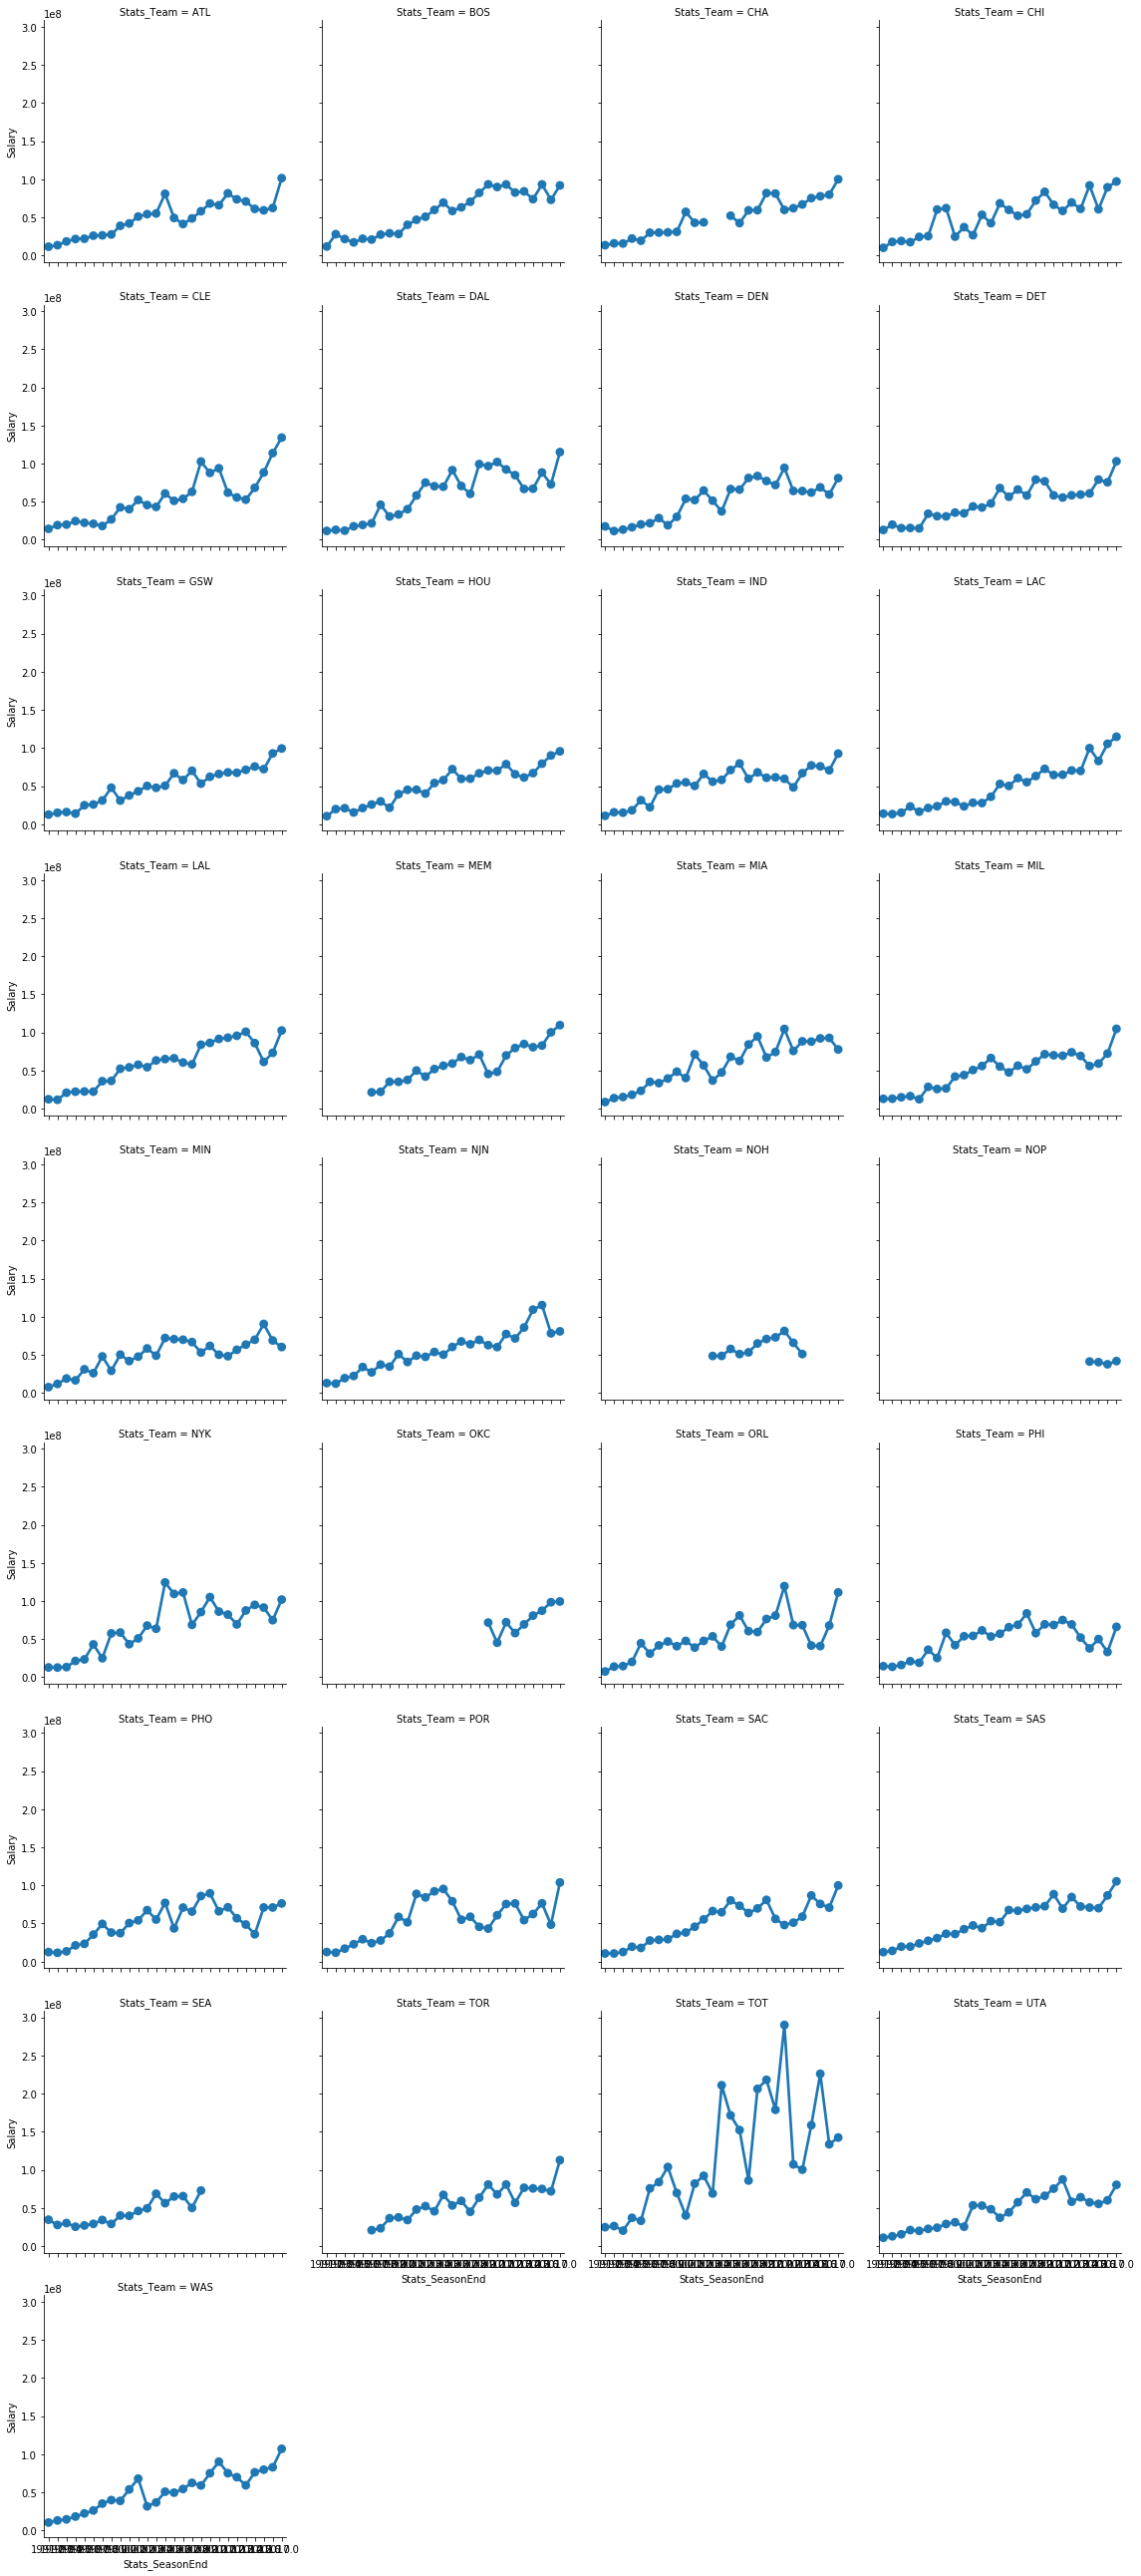

In [23]:
salary_by_year = data.loc[:, ['Stats_Team', 'Stats_SeasonEnd', 'Salary', 'WinShares']].groupby(['Stats_Team', 'Stats_SeasonEnd']).sum(axis=1)
salary_by_year.reset_index(inplace=True)

sns.factorplot(x='Stats_SeasonEnd', y='Salary', col='Stats_Team', col_wrap=4, data=salary_by_year);

In [24]:
data.corr().to_csv('datacorrelations.csv')

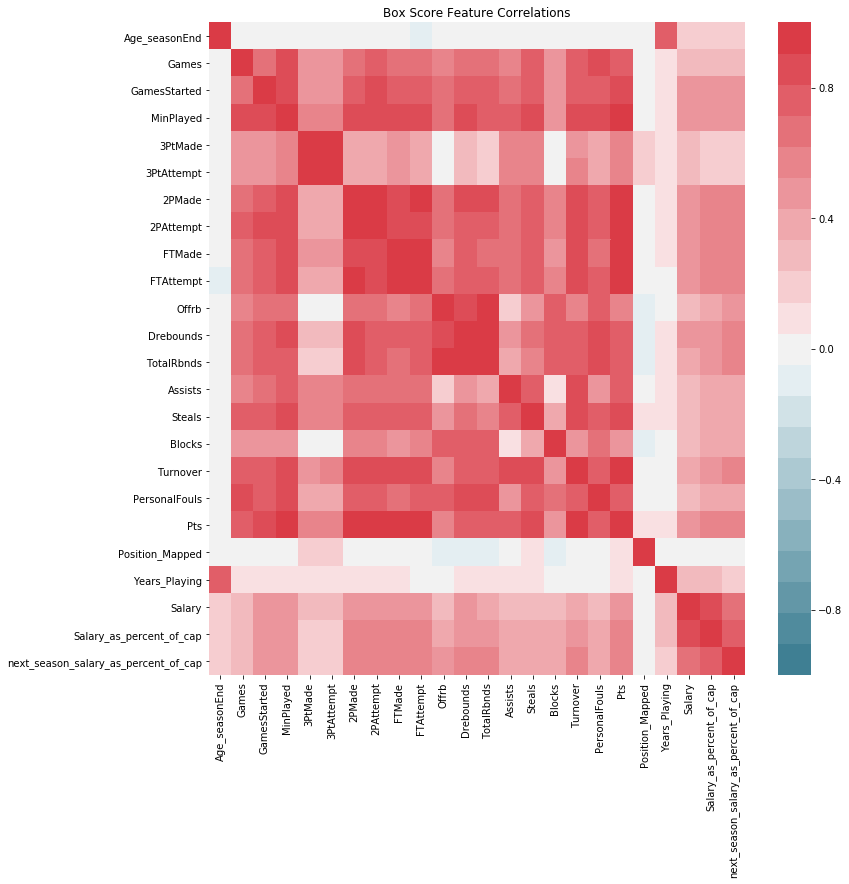

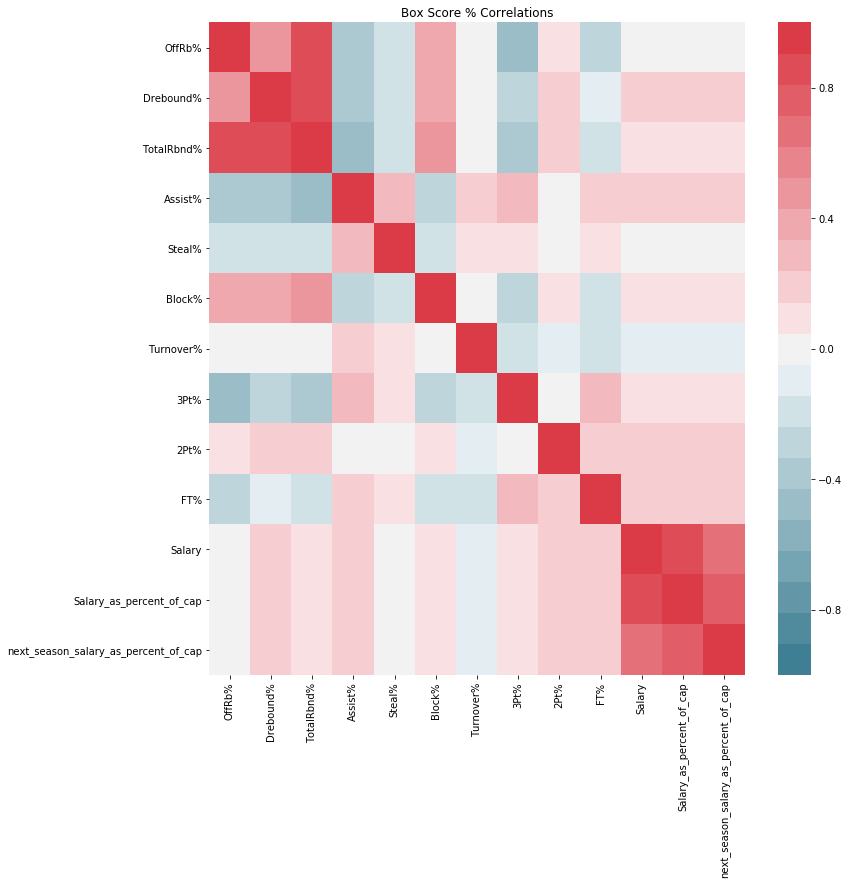

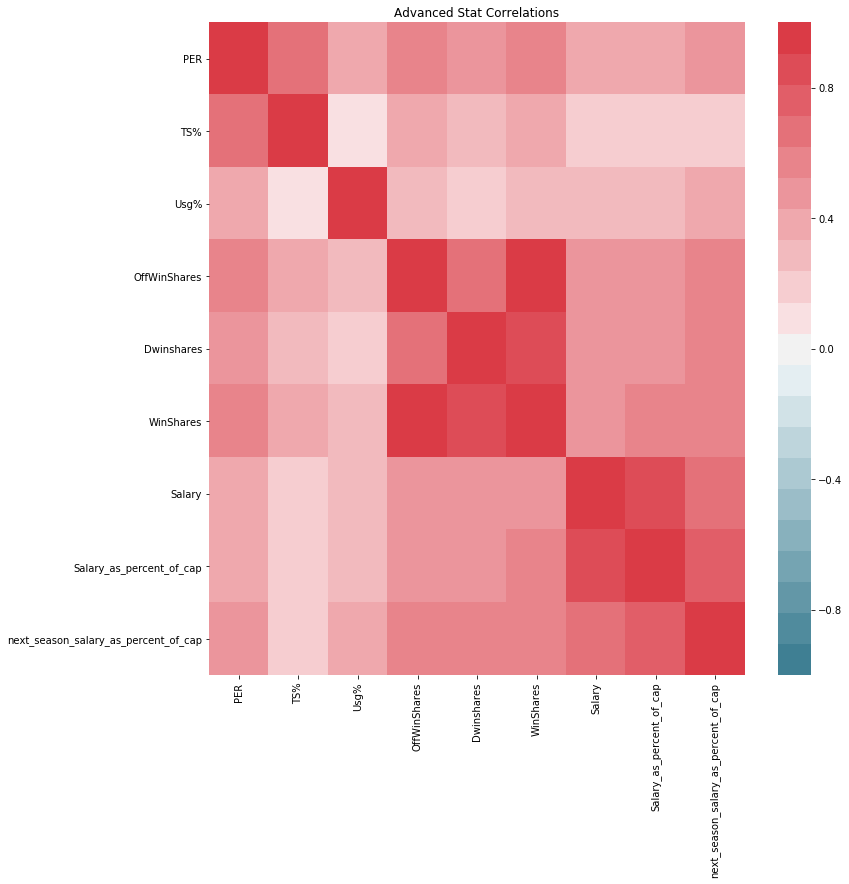

In [25]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data.loc[:, ['Age_seasonEnd','Games','GamesStarted','MinPlayed',
                      '3PtMade','3PtAttempt','2PMade','2PAttempt',
                      'FTMade','FTAttempt','Offrb','Drebounds','TotalRbnds','Assists',
                      'Steals','Blocks','Turnover','PersonalFouls','Pts','Position_Mapped', 'Years_Playing', 'Salary',
                        'Salary_as_percent_of_cap', 'next_season_salary_as_percent_of_cap']].corr(),
            vmin = -1,
           vmax = 1,
           cmap = sns.diverging_palette(220,10,n=21),
           ax=ax);
ax.set_title('Box Score Feature Correlations');

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data.loc[:, ['OffRb%','Drebound%','TotalRbnd%','Assist%','Steal%','Block%','Turnover%',
                         '3Pt%','2Pt%','FT%', 'Salary', 'Salary_as_percent_of_cap', 'next_season_salary_as_percent_of_cap']].corr(),
            vmin = -1,
           vmax = 1,
           cmap = sns.diverging_palette(220,10,n=21),
           ax=ax);
ax.set_title('Box Score % Correlations');


fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data.loc[:, ['PER','TS%','Usg%','OffWinShares','Dwinshares','WinShares', 'Salary', 'Salary_as_percent_of_cap',
                        'next_season_salary_as_percent_of_cap']].corr(),
            vmin = -1,
           vmax = 1,
           cmap = sns.diverging_palette(220,10,n=21),
           ax=ax);
ax.set_title('Advanced Stat Correlations');

### Correlation map observations: there is a lot of multicollinearity in the dataset!
- Box score stats are highly correlated (makes sense, a player who has a high volume of 2pts probably has a high volume of 3pts; higher minutes played should correlate with higher points scored, etc.
    - Some columns are function of others: 'Pts' = 2*'2Pt' + 3*'3Pt' + 1*'FT'
- Box score %s are function of box score fields; percentages aren't a good sole-indicator, because we'd rather have someone who has an 80% FT % out of 100 FTs, than someone with a 100% FT %, but only out of 2 total free throws in the season!
- Advanced stats are function of box score stats already, so should not use both in a model later

- Therefore, need to be careful which of these columns I include in a model, a lot of them will not add additional information

Interesting correlations:
- Salary more correlated with 2pt stats than 3pt
- Positively correlated with defensive rebound%, but negative with offensive rebound %
- Position not super important

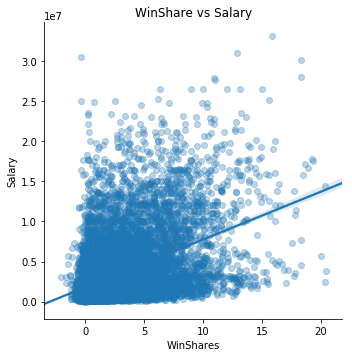

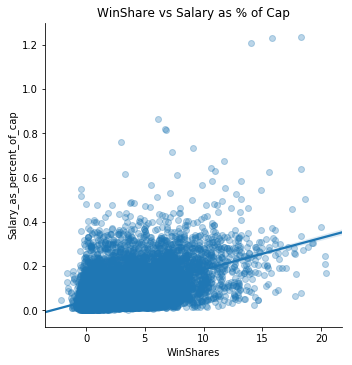

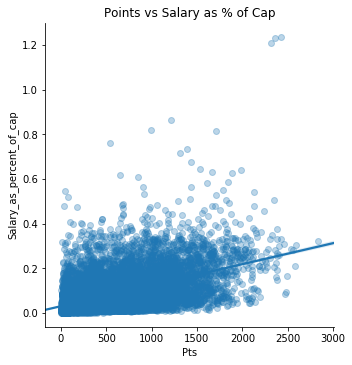

In [26]:
#Salary vs Win Share Columns

morethan70minperseason = data.loc[data.loc[:, 'MinPlayed'] >= 70, :]

sns.lmplot(data=morethan70minperseason, x='WinShares', y='Salary', scatter_kws={'alpha':0.3})
ax = plt.gca()
ax.set_title("WinShare vs Salary")

sns.lmplot(data=morethan70minperseason, x='WinShares', y='Salary_as_percent_of_cap', scatter_kws={'alpha':0.3})
ax = plt.gca()
ax.set_title("WinShare vs Salary as % of Cap")

sns.lmplot(data=morethan70minperseason, x='Pts', y='Salary_as_percent_of_cap', scatter_kws={'alpha':0.3})
ax = plt.gca()
ax.set_title("Points vs Salary as % of Cap");

# Modeling!

### Starting with null model:
- For null model, assume salary as % of cap is always equal to an equal distribution among 12 players/team, which is 100/12 = 8.33%

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

rmse_dict = {}

##### Setting model dataset
- I want to look only at rows where a next_season_salary is filled in, and where minplayed >140 (removes players who played very little!)


In [28]:

modeldata = data.loc[(data.loc[:, 'next_season_salary'].notnull()) & 
                     (data.loc[:, 'MinPlayed'] > 140), :]
modeldata.loc[:, 'prediction'] = .083333
nullrmse = np.sqrt(metrics.mean_squared_error(modeldata.next_season_salary_as_percent_of_cap, modeldata.prediction))
rmse_dict['nullrmse'] = nullrmse

C:\Users\testr\Anaconda\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\testr\Anaconda\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [29]:
#Setup a few feature_cols lists
box_score_features = ['Age_seasonEnd','Games','GamesStarted','MinPlayed',
                      'Fgmade','Fgattempt','3PtMade','3PtAttempt','2PMade','2PAttempt',
                      'FTMade','FTAttempt','Offrb','Drebounds','TotalRbnds','Assists',
                      'Steals','Blocks','Turnover','PersonalFouls','Pts','Position_Mapped', 'Years_Playing']
box_score_percentages = ['OffRb%','Drebound%','TotalRbnd%','Assist%','Steal%','Block%','Turnover%','Usg%',
                         '3Pt%','2Pt%','FT%']
combo_features = ['PER','TS%','Usg%','OffWinShares','Dwinshares','WinShares']

#These ones remove some more redundant/highly correlated fields:
# removes anything 'attempt', removes 'total' when we have a defensive & offensive field
# Removes games & games played in favor of minplayed --> still super highly correlated to all stats, though - remove?
box_score_feature_cols = ['Age_seasonEnd', 'MinPlayed', '3PtMade',
       '2PMade', 'FTMade','Offrb', 'Drebounds', 'Assists',
       'Steals', 'Blocks', 'Turnover', 'PersonalFouls', 'Pts',  'Years_Playing',
       'Position_Mapped']
advanced_stat_feature_cols = [ 'PER', 'TS%', 'OffRb%',
       'Drebound%', 'Assist%', 'Steal%', 'Block%', 'Turnover%',
       'Usg%', 'OffWinShares', 'Dwinshares', 'WinShares']

all_feature_cols = ['Age_seasonEnd', 'MinPlayed', '3PtMade',
       '2PMade', 'FTMade','Offrb', 'Drebounds', 'Assists',
       'Steals', 'Blocks', 'Turnover', 'PersonalFouls', 'Pts',  'Years_Playing',
       'Position_Mapped', 'PER', 'TS%', 'OffRb%',
       'Drebound%', 'Assist%', 'Steal%', 'Block%', 'Turnover%',
       'Usg%', 'OffWinShares', 'Dwinshares', 'WinShares']

In [30]:
#Box score stats linreg
X = modeldata.loc[:, box_score_feature_cols]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

scaler = StandardScaler()
X = scaler.fit_transform(X)

linreg = LinearRegression()
linreg.fit(X, y)

score = (cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))

box_score_vs_next_season_sal_rmse = np.mean(np.sqrt(-score))
box_score_vs_next_season_sal_rmse
rmse_dict['boxscore_only_linreg'] = box_score_vs_next_season_sal_rmse

In [31]:
#Box score stats minus minplayed 
X = modeldata.loc[:, ['Age_seasonEnd', '3PtMade',
       '2PMade', 'FTMade','Offrb', 'Drebounds', 'Assists',
       'Steals', 'Blocks', 'Turnover', 'PersonalFouls', 'Pts',  'Years_Playing',
       'Position_Mapped']]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

scaler = StandardScaler()
X = scaler.fit_transform(X)

linreg = LinearRegression()
linreg.fit(X, y)

score = (cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))

box_score_vs_next_season_sal_rmse = np.mean(np.sqrt(-score))
box_score_vs_next_season_sal_rmse
rmse_dict['boxscore_nominplayed_linreg'] = box_score_vs_next_season_sal_rmse

In [32]:
#Just advanced stats linreg

X = modeldata.loc[:, advanced_stat_feature_cols]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

scaler = StandardScaler()
X = scaler.fit_transform(X)

linreg = LinearRegression()
linreg.fit(X, y)

score = (cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
combo_stats_rmse = np.mean(np.sqrt(-score))
rmse_dict['advancedstats_linreg'] = combo_stats_rmse

In [33]:
#Box + advanced stats

X = modeldata.loc[:, all_feature_cols]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

linreg = LinearRegression()
linreg.fit(Xs, y)

linregscore = (cross_val_score(linreg, Xs, y, cv=10, scoring='neg_mean_squared_error'))
combo_stats_rmse = np.mean(np.sqrt(-linregscore))
rmse_dict['allfeaturecols_linreg'] = combo_stats_rmse

In [34]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(linreg.coef_))], axis = 1)
coefficients.to_csv('linregcoeffs.csv')


In [35]:
linreg.get_params

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)>

In [36]:
rmse_dict

{'advancedstats_linreg': 0.0641716038719923,
 'allfeaturecols_linreg': 0.0626764621937734,
 'boxscore_nominplayed_linreg': 0.06441473457657067,
 'boxscore_only_linreg': 0.06403079978052009,
 'nullrmse': 0.08423383287791675}

## Decision Trees!

In [37]:
from sklearn.tree import DecisionTreeRegressor

X = modeldata.loc[:, box_score_feature_cols]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

# List of values to try:
max_depth_range = list(range(1, 20))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use LOOCV with each value of max_depth.
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

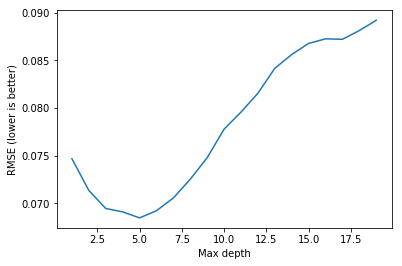

In [38]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('Max depth')
plt.ylabel('RMSE (lower is better)');

In [39]:
treereg = DecisionTreeRegressor(max_depth=5, random_state=1)
treereg.fit(X,y)

importance = pd.DataFrame({'features': box_score_feature_cols, 'importance':treereg.feature_importances_})
importance.sort_values('importance', ascending=False)
scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
rmse_dict['decisiontree_box_score_stats'] = np.mean(np.sqrt(-scores))

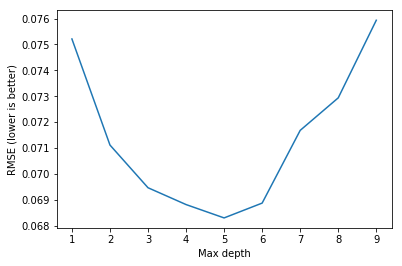

In [40]:
X = modeldata.loc[:, advanced_stat_feature_cols]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

# List of values to try:
max_depth_range = list(range(1, 10))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use LOOCV with each value of max_depth.
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('Max depth')
plt.ylabel('RMSE (lower is better)');

In [41]:
treereg = DecisionTreeRegressor(max_depth=5, random_state=1)
treereg.fit(X,y)

importance = pd.DataFrame({'features': advanced_stat_feature_cols, 'importance':treereg.feature_importances_})
importance.sort_values('importance', ascending=False)
scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
rmse_dict['decisiontree_advanced_stats'] = np.mean(np.sqrt(-scores))

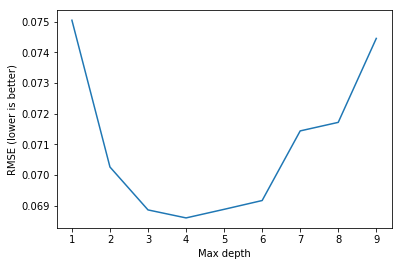

In [42]:
X = modeldata.loc[:, all_feature_cols]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

# List of values to try:
max_depth_range = list(range(1, 10))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use LOOCV with each value of max_depth.
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('Max depth')
plt.ylabel('RMSE (lower is better)');

In [43]:
treereg = DecisionTreeRegressor(max_depth=4, random_state=1)
treereg.fit(X,y)

importance = pd.DataFrame({'features': all_feature_cols, 'importance':treereg.feature_importances_})
importance.sort_values('importance', ascending=False)
scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
rmse_dict['decisiontree_all_stats'] = np.mean(np.sqrt(-scores))

In [44]:
importance.sort_values('importance', ascending=False)

#Shows that only a few columns are important, but that's highly unlikely...2PMade should not be that high!

,features,importance
3,2PMade,0.626380
15,PER,0.232576
13,Years_Playing,0.102714
26,WinShares,0.026391
23,Usg%,0.011940
4,FTMade,0.000000
16,TS%,0.000000
25,Dwinshares,0.000000
24,OffWinShares,0.000000
22,Turnover%,0.000000


In [45]:
rmse_dict

{'advancedstats_linreg': 0.0641716038719923,
 'allfeaturecols_linreg': 0.0626764621937734,
 'boxscore_nominplayed_linreg': 0.06441473457657067,
 'boxscore_only_linreg': 0.06403079978052009,
 'decisiontree_advanced_stats': 0.06829940734933763,
 'decisiontree_all_stats': 0.06859902544121241,
 'decisiontree_box_score_stats': 0.06848357929151556,
 'nullrmse': 0.08423383287791675}

### Random Forest on all columns
- Note: originally ran at n_estimators = 150, but then ran the code to tune the value and found 225 to win out, so rerunning code at that

In [46]:
#reminder of what column groupings I setup...
#Setup a few feature_cols lists
box_score_features = ['Age_seasonEnd','Games','GamesStarted','MinPlayed',
                      'Fgmade','Fgattempt','3PtMade','3PtAttempt','2PMade','2PAttempt',
                      'FTMade','FTAttempt','Offrb','Drebounds','TotalRbnds','Assists',
                      'Steals','Blocks','Turnover','PersonalFouls','Pts','Position_Mapped', 'Years_Playing']
box_score_percentages = ['OffRb%','Drebound%','TotalRbnd%','Assist%','Steal%','Block%','Turnover%','Usg%',
                         '3Pt%','2Pt%','FT%']
combo_features = ['PER','TS%','Usg%','OffWinShares','Dwinshares','WinShares']

#These ones remove some more redundant/highly correlated fields:
# removes anything 'attempt', removes 'total' when we have a defensive & offensive field
# Removes games & games played in favor of minplayed --> still super highly correlated to all stats, though - remove?
box_score_feature_cols = ['Age_seasonEnd', 'MinPlayed', '3PtMade',
       '2PMade', 'FTMade','Offrb', 'Drebounds', 'Assists',
       'Steals', 'Blocks', 'Turnover', 'PersonalFouls', 'Pts',  'Years_Playing',
       'Position_Mapped']
advanced_stat_feature_cols = [ 'PER', 'TS%', 'OffRb%',
       'Drebound%', 'Assist%', 'Steal%', 'Block%', 'Turnover%',
       'Usg%', 'OffWinShares', 'Dwinshares', 'WinShares']

all_feature_cols = ['Age_seasonEnd', 'MinPlayed', '3PtMade',
       '2PMade', 'FTMade','Offrb', 'Drebounds', 'Assists',
       'Steals', 'Blocks', 'Turnover', 'PersonalFouls', 'Pts',  'Years_Playing',
       'Position_Mapped', 'PER', 'TS%', 'OffRb%',
       'Drebound%', 'Assist%', 'Steal%', 'Block%', 'Turnover%',
       'Usg%', 'OffWinShares', 'Dwinshares', 'WinShares']

every_column = ['Age_seasonEnd', 'Stats_Team',
       'Games', 'GamesStarted', 'MinPlayed', 'PER', 'TS%', 'OffRb%',
       'Drebound%', 'TotalRbnd%', 'Assist%', 'Steal%', 'Block%', 'Turnover%',
       'Usg%', 'OffWinShares', 'Dwinshares', 'WinShares', '3PtMade',
       '3PtAttempt', '3Pt%', '2PMade', '2PAttempt', '2Pt%', 'FTMade',
       'FTAttempt', 'FT%', 'Offrb', 'Drebounds', 'TotalRbnds', 'Assists',
       'Steals', 'Blocks', 'Turnover', 'PersonalFouls', 'Pts', 'Salary',
       'next_season_salary', 'next_season_winshares',
       'next_season_off_winshares', 'next_season_def_winshares',
       'Player_first_year', 'Years_Playing', 'Position_Mapped']

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X = modeldata.loc[:, all_feature_cols]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

rfreg = RandomForestRegressor(n_estimators=225,
                             max_features=5,
                             oob_score=True,
                             random_state=1)
rfreg.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=225, n_jobs=1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [ ]:
scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
rmse_dict['random_forest'] = np.mean(np.sqrt(-scores))

In [ ]:
rmse_dict

### Reduce X to its most important features and rerun

In [ ]:
from sklearn.model_selection import train_test_split
X = modeldata.loc[:, all_feature_cols]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

rfreg = RandomForestRegressor(n_estimators=225, max_features=5, oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)

In [ ]:
# Set a threshold for which features to include.
# /scrub/
from sklearn.feature_selection import SelectFromModel

print(SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_train).shape)
print(SelectFromModel(rfreg, threshold='median', prefit=True).transform(X_train).shape)

In [ ]:
# Create a new feature matrix that only includes important features.
# /scrub/
X_important_mean =  SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_test)
X_important_median = SelectFromModel(rfreg, threshold='median', prefit=True).transform(X_test)

In [ ]:
#Important columns by mean:
np.array(X_train.columns.tolist())[SelectFromModel(rfreg, threshold='mean', prefit=True).get_support()]

In [ ]:
#Important columns by median:
np.array(X_train.columns.tolist())[SelectFromModel(rfreg, threshold='median', prefit=True).get_support()]

In [ ]:
rfreg = RandomForestRegressor(n_estimators=225, max_features=5, random_state=1)

scores = cross_val_score(rfreg, X_important_mean, y_test, cv=10, scoring='neg_mean_squared_error')
rmse_dict['random_forest_feature_reduce_by_mean'] = np.mean(np.sqrt(-scores))

rfreg = RandomForestRegressor(n_estimators=225, max_features=5, random_state=1)

scores = cross_val_score(rfreg, X_important_median, y_test, cv=10, scoring='neg_mean_squared_error')
rmse_dict['random_forest_feature_reduce_by_median'] = np.mean(np.sqrt(-scores))

In [ ]:
rmse_dict

### Another try with feature reduce, but only using advanced stats + player info

In [303]:
feature_cols = [ 'PER', 'TS%', 'OffRb%',
       'Drebound%', 'Assist%', 'Steal%', 'Block%', 'Turnover%',
       'Usg%', 'OffWinShares', 'Dwinshares', 'WinShares', 'Age_seasonEnd','Years_Playing', 'Position_Mapped']

X = modeldata.loc[:, feature_cols]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

rfreg = RandomForestRegressor(n_estimators=225,
                             max_features=5,
                             oob_score=True,
                             random_state=1)
rfreg.fit(X_train, y_train)

X_important_mean =  SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_test)
X_important_median = SelectFromModel(rfreg, threshold='median', prefit=True).transform(X_test)

In [304]:
scores = cross_val_score(rfreg, X_important_mean, y_test, cv=10, scoring='neg_mean_squared_error')
rmse_dict['random_forest_advanced_feature_reduce_by_mean'] = np.mean(np.sqrt(-scores))

scores = cross_val_score(rfreg, X_important_median, y_test, cv=10, scoring='neg_mean_squared_error')
rmse_dict['random_forest_advanced_feature_reduce_by_median'] = np.mean(np.sqrt(-scores))

In [305]:
rmse_dict

{'advancedstats_linreg': 0.0641716038719923,
 'allfeaturecols_linreg': 0.0626764621937734,
 'boxscore_nominplayed_linreg': 0.06441473457657067,
 'boxscore_only_linreg': 0.06403079978052009,
 'decisiontree_advanced_stats': 0.06829940734933763,
 'decisiontree_all_stats': 0.06859902544121241,
 'decisiontree_box_score_stats': 0.06848357929151556,
 'nullrmse': 0.08423383287791675,
 'random_forest': 0.06255313933147312,
 'random_forest_advanced_feature_reduce_by_mean': 0.06681064140103002,
 'random_forest_advanced_feature_reduce_by_median': 0.0625078831221773,
 'random_forest_feature_reduce_by_mean': 0.06192629376324782,
 'random_forest_feature_reduce_by_median': 0.061505938331108324}

In [306]:
rmse_by_model_attempt = pd.DataFrame.from_dict(rmse_dict, orient='index')
rmse_by_model_attempt.reset_index(inplace=True)
rmse_by_model_attempt.columns = ['Model_Try', 'RMSE']
rmse_by_model_attempt.sort_values(by='RMSE').to_csv('RMSE_Scores.csv')

In [372]:
feature_cols = [ 'Age_seasonEnd', 'MinPlayed', '3PtMade',
       '2PMade', 'FTMade','Offrb', 'Drebounds', 'Assists',
       'Steals', 'Blocks', 'Turnover', 'PersonalFouls', 'Pts',  'Years_Playing',
       'Position_Mapped', 'TS%', 'OffRb%',
       'Drebound%', 'Assist%', 'Steal%', 'Block%', 'Turnover%',
       'Usg%']

X = modeldata.loc[:, feature_cols]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

rfreg = RandomForestRegressor(n_estimators=225,
                             max_features=5,
                             oob_score=True,
                             random_state=1)
rfreg.fit(X_train, y_train)

X_important_mean =  SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_test)
X_important_median = SelectFromModel(rfreg, threshold='median', prefit=True).transform(X_test)

In [373]:
scores = cross_val_score(rfreg, X_important_mean, y_test, cv=10, scoring='neg_mean_squared_error')
rmse_dict['random_forest_featurenoagg_reduce_by_mean'] = np.mean(np.sqrt(-scores))

scores = cross_val_score(rfreg, X_important_median, y_test, cv=10, scoring='neg_mean_squared_error')
rmse_dict['random_forest_featurenoagg_reduce_by_median'] = np.mean(np.sqrt(-scores))

In [374]:
rmse_dict

{'advancedstats_linreg': 0.0641716038719923,
 'allfeaturecols_linreg': 0.0626764621937734,
 'boxscore_nominplayed_linreg': 0.06441473457657067,
 'boxscore_only_linreg': 0.06403079978052009,
 'decisiontree_advanced_stats': 0.06829940734933763,
 'decisiontree_all_stats': 0.06859902544121241,
 'decisiontree_box_score_stats': 0.06848357929151556,
 'nullrmse': 0.08423383287791675,
 'random_forest': 0.06255313933147312,
 'random_forest_advanced_feature_reduce_by_mean': 0.06681064140103002,
 'random_forest_advanced_feature_reduce_by_median': 0.0625078831221773,
 'random_forest_feature_reduce_by_mean': 0.06192629376324782,
 'random_forest_feature_reduce_by_median': 0.061505938331108324,
 'random_forest_featurenoagg_reduce_by_mean': 0.06347578866105144,
 'random_forest_featurenoagg_reduce_by_median': 0.062455532286183266}

### Tune n_estimators & max_features

In [122]:
# List of values to try for n_estimators:
estimator_range = list(range(150, 300, 25))

# List to store the average RMSE for each value of n_estimators:
RMSE_scores = []

X = modeldata.loc[:, all_feature_cols]

# Use five-fold cross-validation with each value of n_estimators (Warning: Slow!).
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

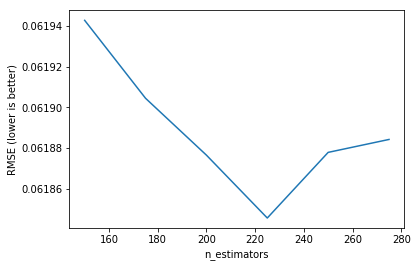

In [123]:
plt.plot(estimator_range, RMSE_scores);

plt.xlabel('n_estimators');
plt.ylabel('RMSE (lower is better)');

Looks like ~225 is the best out of the range I tested - rerunning above random forests with that n_estimator

In [125]:
# List of values to try for max_features:
# There are 27 features, so I'll iterate by 3s to make this slightly faster, using the n_estimator=225 I found above...
feature_range = list(range(1, len(all_feature_cols)+1, 3))

# List to store the average RMSE for each value of max_features:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_features (Warning: Super slow!).
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=225, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

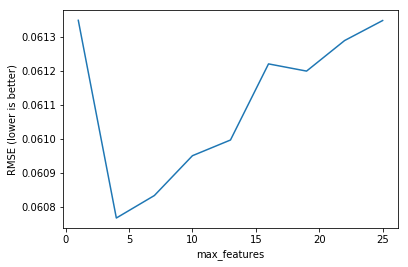

In [126]:
# Plot max_features (x-axis) versus RMSE (y-axis).

plt.plot(feature_range, RMSE_scores);

plt.xlabel('max_features');
plt.ylabel('RMSE (lower is better)');

I'll stick with 5!

# Final charts & conclusions
- Winning model was the random forest that I did feature reduction by median

In [366]:
#Rebuild the winning model since I overrode every single one...
X = modeldata.loc[:, all_feature_cols]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

rfreg = RandomForestRegressor(n_estimators=225, max_features=5, random_state=1)
rfreg.fit(X_train, y_train)

X_important_median_train = SelectFromModel(rfreg, threshold='median', prefit=True).transform(X_train)
X_important_median_test = SelectFromModel(rfreg, threshold='median', prefit=True).transform(X_test)

train_important_cols = np.array(X_train.columns.tolist())[SelectFromModel(rfreg, threshold='median', prefit=True).get_support()]

rfreg = RandomForestRegressor(n_estimators=225, max_features=5, random_state=1)
rfreg.fit(X_important_median_train, y_train)
scores = cross_val_score(rfreg, X_important_median_test, y_test, cv=10, scoring='neg_mean_squared_error')

np.mean(np.sqrt(-scores))

0.061505938331108324

In [367]:
from sklearn.model_selection import cross_val_predict
y_pred_class = cross_val_predict(rfreg, X_important_median_test, y_test, cv=10)

In [371]:
pd.DataFrame(y_pred_class).sort_values(by=0,ascending=False)

X_test.iloc[[2457, 641, 2242, 1142, 1600, 887, 670],:]

#data.loc[data.loc[:, 'MinPlayed'] == 3034,:]

,Age_seasonEnd,MinPlayed,3PtMade,2PMade,FTMade,Offrb,Drebounds,Assists,Steals,Blocks,...,OffRb%,Drebound%,Assist%,Steal%,Block%,Turnover%,Usg%,OffWinShares,Dwinshares,WinShares
Michael Jordan1991.0CHI,27.0,3034.0,29.0,961.0,571.0,118.0,374.0,453.0,223.0,83.0,...,4.6,14.3,25.2,3.7,1.7,8.7,32.9,14.9,5.4,20.3
David Robinson1994.0SAS,28.0,3241.0,10.0,830.0,693.0,241.0,614.0,381.0,139.0,265.0,...,8.8,20.3,21.6,2.3,5.4,10.9,32.0,13.3,6.7,20.0
LeBron James2010.0CLE,25.0,2966.0,129.0,639.0,593.0,71.0,483.0,651.0,125.0,77.0,...,3.0,18.5,41.8,2.2,2.0,12.3,33.5,13.3,5.2,18.5
Hakeem Olajuwon1993.0HOU,30.0,3242.0,0.0,848.0,444.0,283.0,785.0,291.0,150.0,342.0,...,10.5,25.9,15.8,2.4,6.5,12.4,28.8,7.9,8.0,15.8
James Harden2016.0HOU,26.0,3125.0,236.0,474.0,720.0,63.0,438.0,612.0,139.0,51.0,...,2.2,15.6,35.4,2.2,1.4,15.9,32.5,10.7,2.6,13.3
Kobe Bryant2006.0LAL,27.0,3277.0,180.0,798.0,696.0,71.0,354.0,360.0,147.0,30.0,...,2.6,12.7,24.1,2.4,0.7,9.0,38.7,11.6,3.7,15.3
Hakeem Olajuwon1994.0HOU,31.0,3277.0,8.0,886.0,388.0,229.0,726.0,287.0,128.0,297.0,...,8.2,23.3,16.4,2.0,5.7,12.3,29.8,6.4,7.9,14.3


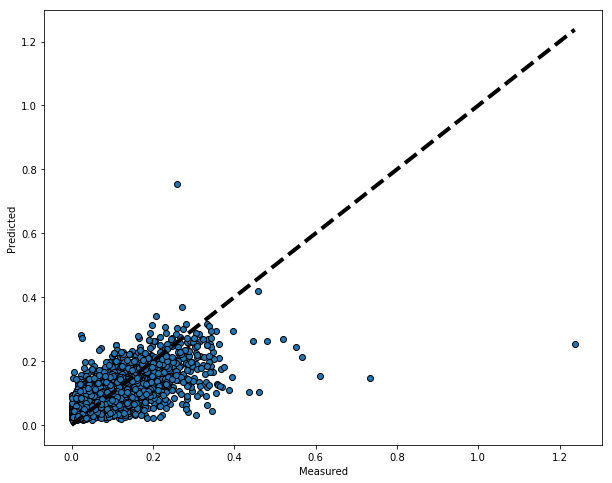

In [358]:
fig, ax = plt.subplots(figsize = (10,8))
ax.scatter(x=y_test, y=y_pred_class, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show();

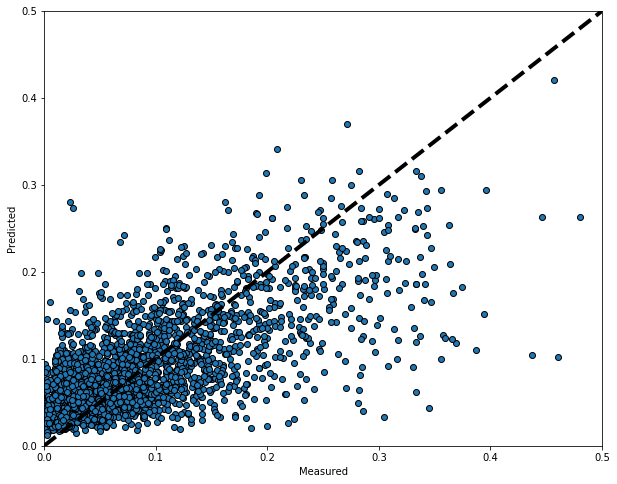

In [359]:
#Zooming in on the majority of datapoints:
fig, ax = plt.subplots(figsize = (10,8))
ax.scatter(x=y_test, y=y_pred_class, edgecolors=(0, 0, 0))
ax.plot([0, 0.5], [0, 0.5], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_xlim(0,0.5)
ax.set_ylim(0,0.5)
plt.show();

In [360]:
pd.DataFrame({'feature': important_cols,
             'importance': rfreg.feature_importances_}).sort_values(by='importance', ascending=False)


,feature,importance
1,2PMade,0.125047
9,PER,0.112201
7,Pts,0.105364
13,WinShares,0.100925
2,FTMade,0.091336
8,Years_Playing,0.071207
3,Drebounds,0.060514
10,Usg%,0.059323
4,Blocks,0.052995
6,PersonalFouls,0.051155


In [337]:
#Notable free agents for next year, let's predict their salary!

free_agents = ['LeBron James', 'Kevin Durant', 'Paul George', 'Chris Paul',
              'Clint Capela', 'DeMarcus Cousins', 'DeAndre Jordan', 'Aaron Gordon',
              'Julius Randle', 'Marcus Smart']

current_season_stat = pd.read_csv('1718stats.csv')

current_season_stat.rename(columns={ '2PA':'2PAttempt', '2P':'2PMade', '2P%':'2Pt%', '3P%':'3Pt%',
 '3PA':'3PtAttempt', '3P':'3PtMade', 'Age':'Age_seasonEnd', 'AST%':'Assist%',
 'AST':'Assists', 'BLK%':'Block%', 'BLK':'Blocks', 'DRB%':'Drebound%',
 'DRB':'Drebounds', 'DWS': 'Dwinshares','FT%':'FT%', 'FTA':'FTAttempt', 'FT':'FTMade', 'G':'Games',
 'GS':'GamesStarted', 'MP':'MinPlayed', 'ORB':'Offrb', 'ORB%':'OffRb%',
 'OWS': 'OffWinShares', 'PER':'PER', 'PF':'PersonalFouls', 'Player':'Player', 'player':'player',
 'Pos':'Position', 'PTS':'Pts', 'salary':'Salary', 'season_end':'Season_End',
 'season_start':'Season_Start', 'STL%':'Steal%', 'STL':'Steals',
 'team':'Team', 'Tm': 'Stats_Team', 'TRB%':'TotalRbnd%', 'TRB':'TotalRbnds',
 'TS%':'TS%', 'TOV':'Turnover', 'TOV%':'Turnover%','USG%':'Usg%', 'WS':'WinShares', 'Year': 'Stats_SeasonEnd'}, inplace=True)

current_season_stat['Stats_SeasonEnd'] = 2018
player_min_year = pd.DataFrame(playerseasondata.groupby('Player')['Year'].min())
player_min_year = player_min_year.to_dict()
player_min_year = player_min_year['Year']
current_season_stat['Player_first_year'] = current_season_stat.Player.map(player_min_year)
current_season_stat['Years_Playing'] = current_season_stat['Stats_SeasonEnd'] - current_season_stat['Player_first_year']

In [338]:
current_season_stat.columns

Index(['Rk', 'Player', 'Position', 'Age_seasonEnd', 'Stats_Team', 'Games',
       'GamesStarted', 'MinPlayed', 'FG', 'FGA', 'FG%', '3PtMade',
       '3PtAttempt', '3Pt%', '2PMade', '2PAttempt', '2Pt%', 'eFG%', 'FTMade',
       'FTAttempt', 'FT%', 'Offrb', 'Drebounds', 'TotalRbnds', 'Assists',
       'Steals', 'Blocks', 'Turnover', 'PersonalFouls', 'Pts', 'PER', 'TS%',
       '3PAr', 'FTr', 'OffRb%', 'Drebound%', 'TotalRbnd%', 'Assist%', 'Steal%',
       'Block%', 'Turnover%', 'Usg%', 'Unnamed: 42', 'OffWinShares',
       'Dwinshares', 'WinShares', 'WS/48', 'Unnamed: 47', 'OBPM', 'DBPM',
       'BPM', 'VORP', 'Stats_SeasonEnd', 'Player_first_year', 'Years_Playing'],
      dtype='object')

In [339]:
free_agents_2018 = current_season_stat.loc[current_season_stat.loc[:, 'Player'].isin(free_agents), important_cols]

In [341]:
predicted_vals = rfreg.predict(free_agents_2018)

current_season_stat.loc[current_season_stat.loc[:, 'Player'].isin(free_agents), ['Player', 'MinPlayed']]

,Player,MinPlayed
103,Clint Capela,2034
134,DeMarcus Cousins,1737
171,Kevin Durant,2325
209,Paul George,2891
215,Aaron Gordon,1909
303,LeBron James,3026
333,DeAndre Jordan,2424
488,Chris Paul,1847
516,Julius Randle,2190
558,Marcus Smart,1614


In [342]:
free_agents_2018['predicted'] = rfreg.predict(free_agents_2018)

In [343]:
free_agents_2018.index = current_season_stat.loc[current_season_stat.loc[:, 'Player'].isin(free_agents), 'Player']

In [344]:
free_agents_2018.to_csv('free_agent_predictions.csv')

,Stats_SeasonEnd,Player,Position,Age_seasonEnd,Stats_Team,Games,GamesStarted,MinPlayed,PER,TS%,...,next_season_winshares,next_season_off_winshares,next_season_def_winshares,Player_first_year,Years_Playing,Position_Mapped,Season_Salary_Cap,Salary_as_percent_of_cap,next_season_salary_as_percent_of_cap,prediction
A.C. Green1991.0LAL,1991.0,A.C. Green,PF,27.0,LAL,82.0,21.0,2164.0,13.8,0.556,...,8.8,5.8,2.9,1986,5.0,1,11871000,0.147418,0.140000,0.083333
A.C. Green1992.0LAL,1992.0,A.C. Green,PF,28.0,LAL,82.0,53.0,2902.0,16.7,0.556,...,8.6,6.1,2.6,1986,6.0,1,12500000,0.140000,0.125000,0.083333
A.C. Green1993.0LAL,1993.0,A.C. Green,PF,29.0,LAL,82.0,55.0,2819.0,16.3,0.603,...,9.3,6.7,2.6,1986,7.0,1,14000000,0.125000,0.124217,0.083333
A.C. Green1994.0PHO,1994.0,A.C. Green,PF,30.0,PHO,82.0,55.0,2825.0,17.0,0.555,...,6.7,4.6,2.1,1986,8.0,1,15175000,0.124217,0.405450,0.083333
A.C. Green1995.0PHO,1995.0,A.C. Green,SF,31.0,PHO,82.0,52.0,2687.0,14.2,0.596,...,4.4,2.7,1.7,1986,9.0,5,15964000,0.405450,0.281435,0.083333
A.C. Green1996.0PHO,1996.0,A.C. Green,SF,32.0,PHO,82.0,36.0,2113.0,12.9,0.558,...,4.8,2.4,2.4,1986,10.0,5,23000000,0.281435,0.084862,0.083333
A.C. Green1997.0TOT,1997.0,A.C. Green,PF,33.0,TOT,83.0,73.0,2492.0,12.4,0.523,...,0.8,0.3,0.5,1986,11.0,1,24363000,0.084862,0.084862,0.083333
A.C. Green1997.0PHO,1997.0,A.C. Green,PF,33.0,PHO,27.0,19.0,548.0,11.6,0.513,...,4.0,2.2,1.8,1986,11.0,1,24363000,0.084862,0.199113,0.083333
A.C. Green1997.0DAL,1997.0,A.C. Green,PF,33.0,DAL,56.0,54.0,1944.0,12.6,0.527,...,5.2,2.8,2.4,1986,11.0,1,24363000,0.199113,0.076859,0.083333
A.C. Green1998.0DAL,1998.0,A.C. Green,PF,34.0,DAL,82.0,68.0,2649.0,12.8,0.496,...,1.4,0.7,0.7,1986,12.0,1,26900000,0.076859,0.170836,0.083333
